# 0 Setup

## 0.1 Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    roc_auc_score,
    accuracy_score
)
from sklearn.model_selection import train_test_split

## 0.2 Funções

In [ ]:
def evaluation(y_true, y_pred, y_pred_proba):
    print(f"Acurácia: {accuracy_score(y_true, y_pred)}")
    print(f"Precision: {precision_score(y_true, y_pred)}")
    print(f"Recall: {recall_score(y_true, y_pred)}")
    print(f"AUC:  {roc_auc_score(y_true, y_pred_proba)}")

# 1 Dados

## 1.1 Gerar dados

Vamos criar um conjunto de dados aleatório com a função `make_classification`. Vamos ter na nossa base 100k pontos e 4 variáveis, das quais apenas duas serão informativas, as outras duas serão ruído.

In [ ]:
X, y = make_classification(
    n_samples=100_000,
    n_features=4,
    n_informative=2,
    flip_y=0.05
)

In [ ]:
X.shape, y.shape

((100000, 4), (100000,))

## 1.2 Dividir os dados

Antes de fazermos o treinamento do modelo, vamos dividir o nosso conjunto de dados em três:

- **Treino**: usado no treinamento do modelo;
- **Validação**: usado para verificar as métricas de qualidade do modelo;
- **Teste**: usado para simular os dados que chegariam no modelo em produção.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=5_000)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=5_000
)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((90000, 4), (5000, 4), (5000, 4))

Para mostrarmos o que acontece quando as variáveis são alteradas, vamos adicionar muito ruído no conjunto de dados de teste, criando um novo conjunto de variáveis explicativas.

In [ ]:
X_test_shift = (
    X_test + 
    np.random.randn(X_test.shape[0]).reshape(-1,1) + 
    np.random.random_sample(X_test.shape[0]).reshape(-1,1)
)

# 2 Treino do modelo

Com os dados em mãos, podemos treinar o modelo. Como aqui estamos interessados apenas em um exemplo simples e não em fazer um super modelo, vamos utilizar a RandomForest padrão do `scikit-learn`.

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

Como sempre, também vamos fazer a avaliação de performance do modelo em um conjunto de dados nunca visto (validação).

In [ ]:
preds_val = clf.predict(X_val)
preds_prob_val = clf.predict_proba(X_val)[:,1]

In [ ]:
evaluation(y_val, preds_val, preds_prob_val)

Acurácia: 0.964
Precision: 0.9694688414889168
Recall: 0.9558762886597938
AUC:  0.9712128115303774


# 3 Monitoramento

Nessa seção, vamos descrever algumas possibilidades de testes para verificar se houve mudança de conceito nos dados ou se o modelo continua com a performance adequada.

## 3.1 Estatística descritiva

Vamos começar falando das variáveis explicativas. A alteração na distribuição de uma variável pode ser o suficiente para que o modelo perca performance rapidamente, por isso devemos estar atentos a qualquer tipo de mudança que elas possam sofrer (mudança de comportamento, sazonalidade, crises, etc.).

Uma maneira de verificar se houveram alterações e analisando as variáveis utilizando medidas de centralidade como média e mediana, por exemplo. Um outra forma, mais visual e manual, é analisando o gráfico das distribuições.

### 3.1.1 Distribuições

Pelo gráfico abaixo, vemos claramente que o conjunto de dados modificado não segue a mesma distribuição dos conjuntos de treino e teste.

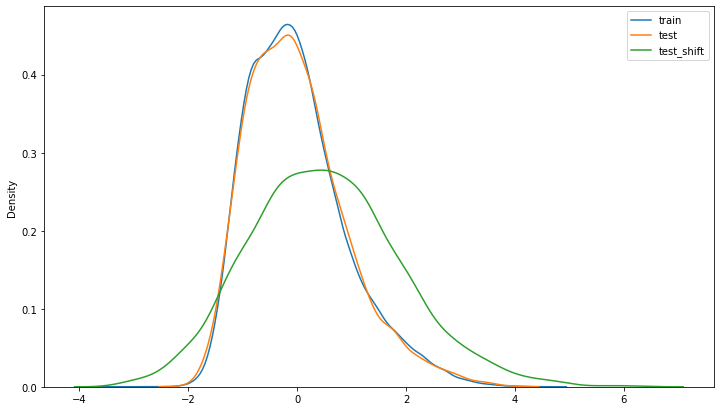

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
sns.kdeplot(X_train[:, 0], ax=ax, label="train")
sns.kdeplot(X_test[:, 0], ax=ax, label="test")
sns.kdeplot(X_test_shift[:, 0], ax=ax, label="test_shift")
plt.legend();

### 3.1.2 Média

A média é umas medidas mais simples que podemos avaliar quando queremos entender algum tipo de desvio de comportamento. Uma mudança na média da variável pode indicar uma mudança de conceito.

In [ ]:
X_train[:, 0].mean(), X_test[:, 0].mean()

(-0.001929329394919779, -0.00023285083321707525)

In [ ]:
X_train[:, 0].mean(), X_test_shift[:, 0].mean()

(-0.001929329394919779, 0.5099532944759658)

## 3.2 KS-test

Apesar de simples e fáceis de compreender, as medidas descritivas podem sofrer com:

- o baixo volume de dados, fazendo com que a média empírica seja diferente, mesmo que ligeiramente;
- falta de um limite definido para decidir o que são medidas iguais e o que são medidas diferentes.

Um modo de mitigar esses problemas é com a utilização de testes estatísticos. Um teste famoso é o chamado **Teste KS**, de *Komolgorov-Smirnov*. A ideia dele é identificar se duas amostras vieram da mesma distribuição. Ele testa essa hipótese, comparando as distribuições acumuladas (**cdf**, do inglês *cummulative distribution function*) das duas amostras. O valor do teste é basicamente a maior diferença encontrada entre as duas curvas.

![KS test example](https://imgs.search.brave.com/AsWF21YrlPW01s8K5tcPqPxagO0TBTQpt4hv7MDDx6g/rs:fit:580:478:1/g:ce/aHR0cHM6Ly91cGxv/YWQud2lraW1lZGlh/Lm9yZy93aWtpcGVk/aWEvY29tbW9ucy9j/L2NmL0tTX0V4YW1w/bGUucG5n)

Vamos analisar então as nossas distribuições.

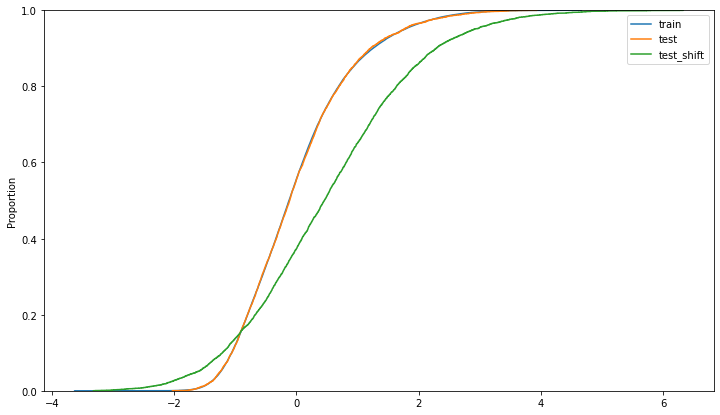

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
sns.ecdfplot(X_train[:, 0], ax=ax, label="train")
sns.ecdfplot(X_test[:, 0], ax=ax, label="test")
sns.ecdfplot(X_test_shift[:, 0], ax=ax, label="test_shift")
plt.legend();

Podemos ver que as distribuições acumuladas de treino e teste seguem a mesma cdf. Isso fica evidente pelo resultado do teste, no qual temos um p_valor > 0.05. Isso significa que não temos evidência suficiente para falar que essas distribuições são diferentes.

In [ ]:
ks_2samp(X_train[:, 0], X_test[:, 0])

KstestResult(statistic=0.007966666666666677, pvalue=0.9221024657160614)

Já quando testamos com os dados modificados, temos um valor muito menor que 0.05. Assim como vimos graficamente, o teste indica que temos evidências suficientes para dizer que as duas amostras vieram de diferentes distribuições.

In [ ]:
ks_2samp(X_train[:, 0], X_test_shift[:, 0])

KstestResult(statistic=0.2373333333333334, pvalue=3.1074057297522626e-235)

## 3.3 Distribuição da saída

Da mesma forma como fizemos com as variáveis de entrada, podemos analisar a distribuição da saída. No caso de um regressor, basta aplicarmos o teste estatístico nas amostras previstas de validação e de teste. Como estamos lidando com um classificador, podemos analisar como está a distribuição de probabilidades na saída.

In [ ]:
preds_prob_test = clf.predict_proba(X_test)[:, 1]
ks_2samp(preds_prob_val, preds_prob_test)

KstestResult(statistic=0.0258, pvalue=0.0717092782360969)

In [ ]:
preds_prob_test_shift = clf.predict_proba(X_test_shift)[:, 1]
ks_2samp(preds_prob_val, preds_prob_test_shift)

KstestResult(statistic=0.4744, pvalue=0.0)

Novamente, os testes indicam que para o conjunto não modificado, não temos evidências de que as amostram sejam de distribuições distintas, mas para os dados modificados sim. Isso ficar mais claro quando analisamos as curvas de distribuição acumulada das probabilidades.

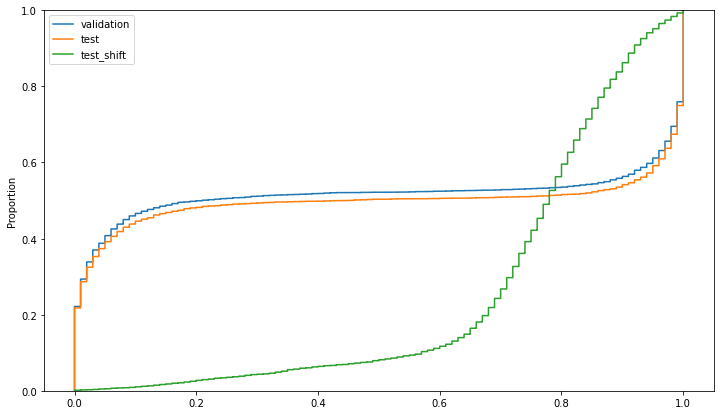

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
sns.ecdfplot(preds_prob_val, ax=ax, label="validation")
sns.ecdfplot(preds_prob_test, ax=ax, label="test")
sns.ecdfplot(preds_prob_test_shift, ax=ax, label="test_shift")
plt.legend();

## 3.4 Avaliação do modelo

Um último modo de avaliar a performance do modelo é justamente medir as métricas novamente quando os dados reais estiverem disponíveis. O maior problema dessa abordagem é que o tempo entre previsão e a mensuração do resultado pode ser muito longo, levando a uma baixa tempestividade na correção do problema.

In [ ]:
preds_test_shift = clf.predict(X_test_shift)
evaluation(y_test, preds_test_shift, preds_prob_test_shift)

Acurácia: 0.5332
Precision: 0.5211236933797909
Recall: 0.9465981012658228
AUC:  0.5771868823225186
